# Оценка сервиса аренды самокатов GoFast

Аналитическая оценка популярного сервиса аренды самокатов GoFast. 
Входные данные: данные о некоторых пользователях из нескольких городов, а также об их поездках. 
Цель исследования: провести анализ данных и вынести предложения для улучшения бизнес-показателей. 

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки
       - абонентская плата отсутствует;
       - стоимость одной минуты поездки — 8 рублей;
       - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
       - абонентская плата — 199 рублей в месяц;
       - стоимость одной минуты поездки — 6 рублей;
       - стоимость старта — бесплатно.
       
В основных данных есть информация о пользователях, их поездках и подписках.

План работы:

    Шаг 1 - Загрузка данных
    Шаг 2 - Предобработка данных
    Шаг 3 - Исследовательский анализ данных
    Шаг 4 - Объединение данных
    Шаг 5 - Подсчет выручки
    Шаг 6 - Проверка гипотез
    Шаг 7 - Распределения
    Общий вывод


Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats as st
from math import sqrt
from math import factorial

import warnings 
warnings.filterwarnings('ignore')

#### Шаг 1. Загрузка данных

In [2]:
try:
    data_users = pd.read_csv
    data_riders = pd.read_csv
    data_subscription = pd.read_csv
except:
    data_users = pd.read_csv
    data_riders = pd.read_csv
    data_subscription = pd.read_csv 

Выведем первые строки датасетов

In [3]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
data_riders.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
data_subscription.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
data_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
data_subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Требуется замена типа данных в столбце date (сейчас тип object), а также проверка на пропущенные значения и дубликаты.

#### Шаг 2. Предобработка данных

##### Изменение типа данных

Приведем данные в столбце date таблицы data_rider к формату datetime.

In [9]:
data_riders['date'] = pd.to_datetime(data_riders['date'], format = '%Y-%m-%d')

Создадим новый столбец с данными месяца на основании столбца date.
В первую очередь, проверим за какие годы представлены данные:

In [10]:
data_riders['date'].dt.year.unique()

array([2021])

Данные представлены в пределах одного года, значит можно сразу приводить данные к месяцу, ошибок не будет.

In [11]:
data_riders['month'] = data_riders['date'].dt.month

##### Пропущенные значения

In [12]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
data_riders.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [14]:
data_subscription.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков в начальных данных не обнаружено.

##### Дубликаты

###### Проверим дубликаты в таблице data_users:

In [15]:
data_users.duplicated().sum()

31

Обнаружен 31 дубликат. Произведем удаление явных дубликатов и проверим результат.

In [16]:
data_users.drop_duplicates(inplace=True)

In [17]:
data_users.duplicated().sum()

0

Дубликаты в таблице data_users удалены.

###### Проверим дубликаты в таблице data_riders:

In [18]:
data_riders.duplicated().sum()

0

Дубликатов в таблице data_riders не выявлено.

###### Проверим дубликаты в таблице data_subscription:

In [19]:
data_subscription.duplicated().sum()

0

Дубликатов в таблице data_subscription не выявлено.

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:
##### Частота встречаемости городов

In [20]:
users_by_city = data_users['city'].value_counts()

In [21]:
users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [22]:
users_by_city['rate'] = round(data_users['city'].value_counts() / 
                            users_by_city.sum()) * 100

<AxesSubplot:title={'center':'Частота встречаемости городов'}, ylabel='city'>

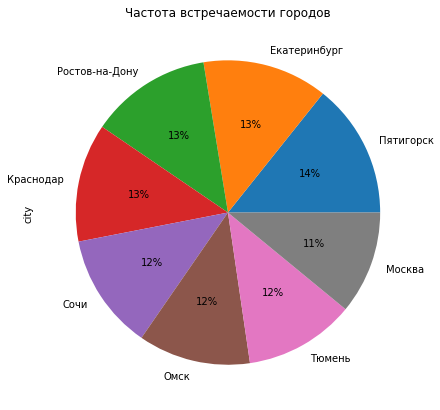

In [23]:
data_users['city'].value_counts().plot(
    kind = 'pie', 
    y = users_by_city,
    autopct = '%1.0f%%',
    figsize=(7,7), title = 'Частота встречаемости городов')

<AxesSubplot:title={'center':'Частота встречаемости городов'}, xlabel='Город', ylabel='Количество пользователей'>

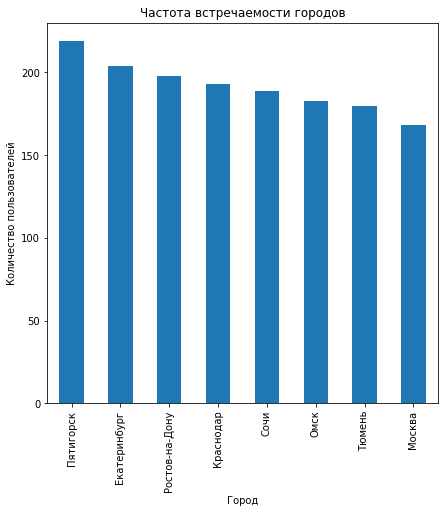

In [24]:
data_users['city'].value_counts().plot(
    kind = 'bar', 
    y = users_by_city,
    xlabel = 'Город',
    ylabel = 'Количество пользователей',
    figsize=(7,7), title = 'Частота встречаемости городов')

Данные распределены по всем городам достаточно равномерно, доли присутствия по разным городам в структуре составляют от 11% до 14%. Наибольшее число пользователей - Пятигорск, 219. Наименьшее - Москва, 168. 

##### Соотношение пользователей с подпиской и без подписки

In [25]:
count_sub = data_users['subscription_type'].value_counts()

In [26]:
count_sub

free     835
ultra    699
Name: subscription_type, dtype: int64

<AxesSubplot:title={'center':'Соотношение пользователей с подпиской и без подписки'}, ylabel='subscription_type'>

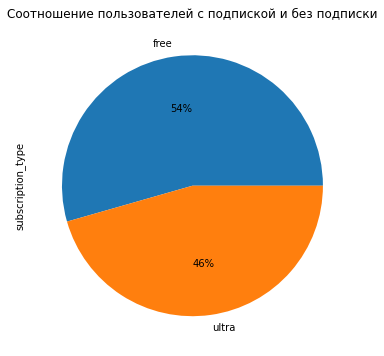

In [27]:
data_users['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = count_sub, 
    autopct = '%1.0f%%',
    figsize=(6,6), title = 'Соотношение пользователей с подпиской и без подписки')

Пользователей без подписки больше, чем с подпиской - 54% против 46%

##### Возраст пользователей

Text(0, 0.5, 'Количество пользователей')

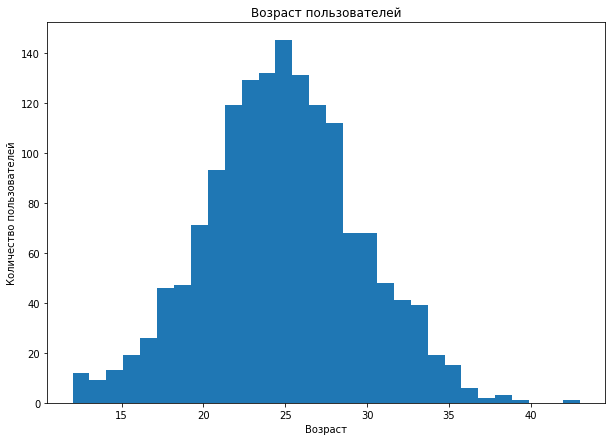

In [28]:
plt.figure(figsize=(10,7))
plt.hist(data_users['age'], bins = 30)
plt.title('Возраст пользователей')

plt.xlabel('Возраст')

plt.ylabel('Количество пользователей')


#plt.show()

Возраст пользователей находится в диапазоне от 12 до 43 лет. Наибольшая часть пользователей находится в возрасте от 20 до 30 лет. Пик приходится на 24 года.

#####  Расстояние, которое пользователь преодолел за одну поездку

(0.0, 8000.0)

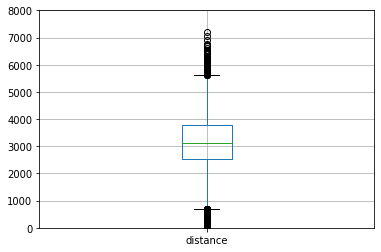

In [29]:
data_riders.boxplot(column=['distance'])
plt.ylim(0, 8000)

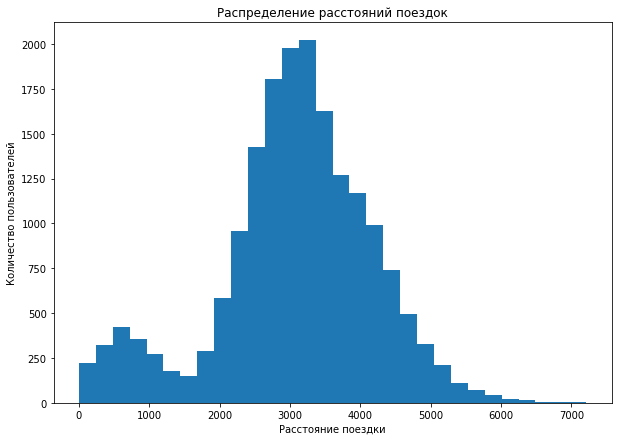

In [30]:
plt.figure(figsize=(10,7))
plt.hist(data_riders['distance'], bins = 30)
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество пользователей')

plt.show()

In [31]:
data_riders['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Расстояние, которое наиболее часто проезжают расположено в диапазоне от 2.5 км до 3.7 км. Наибольшее значение расстояния составляет около 7.2 км. Минимальное значение - 0.86 м. Медианное значение - 3.07 км, среднее 1.16 км. На отметке 0.5 км наблюдается локальный пик.

##### Продолжительность поездок

(0.0, 45.0)

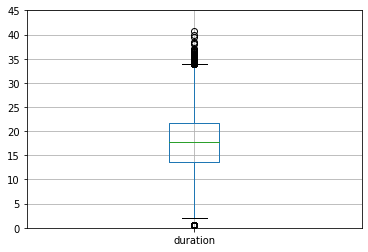

In [32]:
data_riders.boxplot(column=['duration'])
plt.ylim(0, 45)

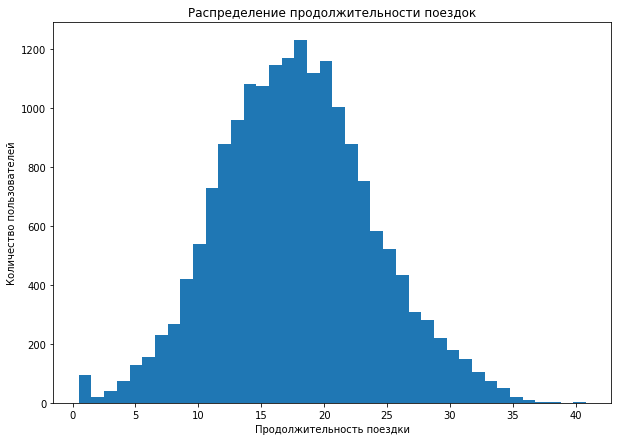

In [33]:
plt.figure(figsize=(10,7))
plt.hist(data_riders['duration'], bins = 40)
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество пользователей')

plt.show()

In [34]:
data_riders['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Продолжительность поездок преимущественно расположена в диапазоне от 12 до 23 минут. Минимальное значение времени поездки - 0,5 мин, что вероятно вызвано человеческим фактором (передумал ехать), либо неисправностью самоката. Пик на отметке 18 минут. Медианное значение- 17,8 м, среднее - 6,09 мин. Самая длительная поездка - 40 минут.

**Выводы:** 
- Данные распределены по всем городам достаточно равномерно, доли присутствия по разным городам в структуре составляют от 11% до 14%. Наибольшее число пользователей - Пятигорск, 219. Наименьшее - Москва, 168. 
- Пользователей без подписки больше, чем с подпиской - 54% против 46%.
- Возраст пользователей находится в диапазоне от 12 до 43 лет. Наибольшая часть пользователей находится в возрасте от 20 до 30 лет. Пик приходится на 24 года.
- Расстояние, которое наиболее часто проезжают расположено в диапазоне от 2.5 км до 3.7 км. Наибольшее значение расстояния составляет около 7.2 км. Минимальное значение - 0.86 м. Медианное значение - 3.07 км, среднее 1.16 км. На отметке 0.5 км наблюдается локальный пик.
- Продолжительность поездок преимущественно расположена в диапазоне от 12 до 23 минут. Минимальное значение времени поездки - 0,5 мин, что вероятно вызвано человеческим фактором (передумал ехать), либо неисправностью самоката. Пик на отметке 18 минут. Медианное значение- 17,8 м, среднее - 6,09 мин. Самая длительная поездка - 40 минут.

#### Шаг 4. Объединение данных

##### Объединяем данные о пользователях, поездках и подписках в один датафрейм.

In [35]:
full_data = data_users.merge(data_riders, on='user_id')

In [36]:
full_data = full_data.merge(data_subscription)

In [37]:
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [38]:
full_data.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,24.893071,3070.659976,17.805011,6.486772,7.280496,32.012398,71.590658
std,434.734317,4.582216,1116.831209,6.091051,3.437410,0.959882,23.997045,95.508238
min,1.000000,12.000000,0.855683,0.500000,1.000000,6.000000,0.000000,0.000000
25%,487.000000,22.000000,2543.226360,13.597563,4.000000,6.000000,0.000000,0.000000
50%,889.000000,25.000000,3133.609994,17.678395,6.000000,8.000000,50.000000,0.000000
75%,1213.250000,28.000000,3776.222735,21.724800,9.000000,8.000000,50.000000,199.000000
max,1534.000000,43.000000,7211.007745,40.823963,12.000000,8.000000,50.000000,199.000000


##### Создаем два датафрейма из датафрейма full_data:
    - c данными о пользователях без подписки;
    - с данными о пользователях с подпиской.

In [39]:
free_sub = full_data.query("`subscription_type` == 'free'")

In [40]:
free_sub.shape[0]

11568

In [41]:
free_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [42]:
ultra_sub = full_data.query("`subscription_type` == 'ultra'")

In [43]:
ultra_sub.shape[0]

6500

In [44]:
ultra_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Расстояние для обоих видов подписки:

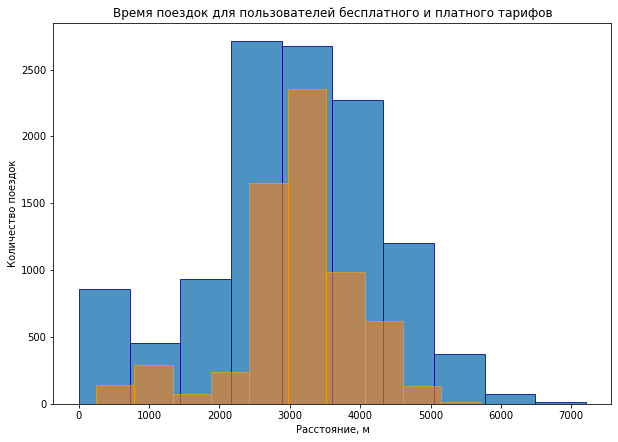

In [45]:
plt.figure(figsize=(10,7))
plt.hist(free_sub['distance'], label="free", alpha=0.8, edgecolor='darkblue')
plt.hist(ultra_sub['distance'], label="ultra", alpha=0.6, edgecolor='orange')
plt.title('Время поездок для пользователей бесплатного и платного тарифов')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

Расстояние для обоих видов подписки:

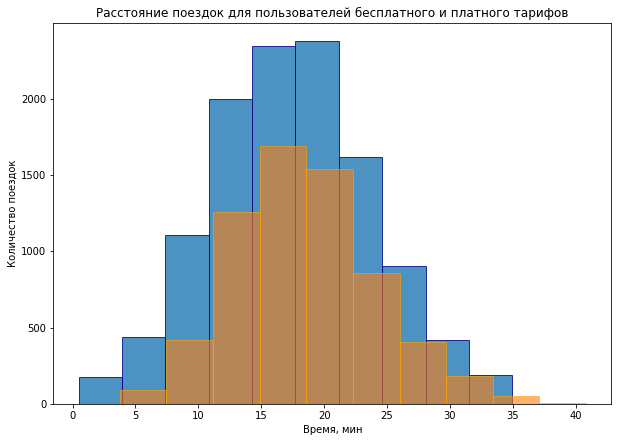

In [46]:
plt.figure(figsize=(10,7))
plt.hist(free_sub['duration'], label="free", alpha=0.8, edgecolor='darkblue')
plt.hist(ultra_sub['duration'], label="ultra", alpha=0.6, edgecolor='orange')
plt.title('Расстояние поездок для пользователей бесплатного и платного тарифов')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.show()

**Выводы:**
- Проведено объединение данных о пользователях, поездках и тарифах в один датафрейм - full_data.
- Из общего датафрейма выделили 
   - free_sub - Информация о пользователях с бесплатным тарифом
   - ultra_sub - Информация о пользователях с платным тарифом
- Визуализирована информация о расстоянии и времени для каждого из тарифов.

- Для платного тарифа время поездки составляет от 10 до 30 минут и проезжают от 2 до 5 км
- Для бесплатного тарифа в основном время укладывается в промежуток от 5 до 35 минут. Большая часть поездок приходится на расстояния от 3 до 6 км.

Можно подытожить, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большие расстояния, чем пользователи на платном тарифе.


#### Шаг 5. Подсчёт выручки

##### Создаем датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4:  суммарное расстояние, суммарное количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [47]:
total_data = pd.pivot_table(full_data,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 'duration' : sum, 'name':len,
                                       'subscription_type' : min})

In [48]:
total_data

distance   duration  name subscription_type
month user_id                                                
1     1        7027.511294  41.416640     2             ultra
      3        3061.777147  12.654443     1             ultra
      5        3914.646990  12.395153     1             ultra
      7        6478.080979  27.653450     2             ultra
      12       3577.151148  32.462907     1             ultra
...                    ...        ...   ...               ...
12    1525     4597.854350  33.220866     1              free
      1526     3644.121544  22.665456     1              free
      1528     3998.569324  10.272902     1              free
      1532     6111.889853  40.128222     2              free
      1534     2371.711192  15.893917     1              free

[11331 rows x 4 columns]

##### В датафрейм добавляем столбец с помесячной выручкой, которую принёс каждый пользователь. 

Округляем значение продолжительности поездки.

In [49]:
data_riders['duration'] = np.ceil(data_riders['duration']) 

Создаем функцию для расчета выручки для каждого из тарифов, а затем добавляем столбец с рассчитанными данными в датафрейм.

In [50]:
def gain(row):
    if row['subscription_type'] == 'ultra':
        return row['duration']*6 + 199
    elif row['subscription_type'] == 'free':
        return row['duration']*8 + 50 * row['name']
    else:
        return 'Нет такого типа данных'

In [51]:
total_data['gain_per_month'] = total_data.apply(gain, axis=1)

Проверим выборку для пользователя с user_id=1

In [52]:
total_data.query('user_id == 1')

,,distance,duration,name,subscription_type,gain_per_month
month,user_id,,,,,
1,1,7027.511294,41.416640,2,ultra,447.499843
4,1,754.159807,6.232113,1,ultra,236.392681
8,1,6723.470560,44.776802,2,ultra,467.660815
10,1,5809.911100,31.578017,2,ultra,388.468102
11,1,7003.499363,53.397424,3,ultra,519.384541
12,1,6751.629942,27.203912,2,ultra,362.223471


**Выводы:**
Создан новый датафрейм с агрегированными данными total_data на основе датафрейма с объединенными данными full_data.

Найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Добавлен столбец с помесячной выручкой, которую принес каждый пользователь.

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Тратят ли пользователи с подпиской больше времени на поездки? 

Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проверим гипотезу: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

- H0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free
- H1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

In [53]:
ultra = ultra_sub['duration'] 
free = free_sub['duration']
alpha = 0.05

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')
print('p-значение:',results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')
    
ultra_results1 = ultra_sub['duration'].mean()
free_results1 = free_sub['duration'].mean()

print('Cредняя оценка длительности поездки тариф ultra:',ultra_results1) 
print('Cредняя оценка длительности поездки тариф free:',free_results1) 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу
Cредняя оценка длительности поездки тариф ultra: 18.54198516280583
Cредняя оценка длительности поездки тариф free: 17.39090929866399


[Text(0.5, 0, 'Номер месяца'), Text(0, 0.5, 'Продолжительность поездок')]

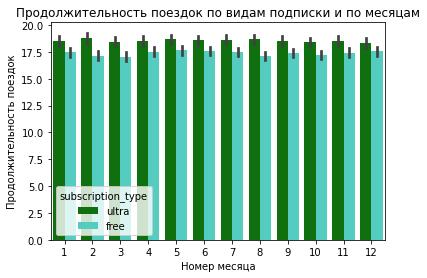

In [54]:
table_1 = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = full_data,
            palette = ['green', 'turquoise'])
table_1.set_title('Продолжительность поездок по видам подписки и по месяцам')
table_1.set(xlabel='Номер месяца', ylabel='Продолжительность поездок')

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Проверим гипотезу: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

- H0: Расстояние (distance) пользователей на подписке ultra = 3130 метров
- H1: Расстояние (distance) пользователей на подписке ultra < 3130 метров

In [55]:
ultra_dist = ultra_sub['distance']
distance_value = 3130.0
alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    distance_value,
    alternative='less')
    
print('p-значение:',results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')
    
ultra_results2 = ultra_sub['distance'].mean()
free_results2 = free_sub['distance'].mean()

print('Cредняя оценка расстояния тариф ultra:',ultra_results2) 
print('Cредняя оценка расстояния тариф free:',free_results2) 

p-значение: 0.08046311521502146
Не удалось отвергнуть нулевую гипотезу
Cредняя оценка расстояния тариф ultra: 3115.4453880370247
Cредняя оценка расстояния тариф free: 3045.495281671816


Нулевая гипотеза не была отвергнута, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров. Наблюдаемое значение оказалось далеко от предполагаемого в нулевой гипотезе.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Проверим гипотезу: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

- H0: Выручка (gain_per_month) пользователей на подписке ultra = выручка (gain_per_month) пользователей на подписке free
- H1: Выручка (gain_per_month) пользователей на подписке ultra > выручка (gain_per_month) пользователей на подписке free

In [56]:
ultra_per_month = total_data.loc[total_data.subscription_type == 'ultra', 'gain_per_month'] 
free_per_month = total_data.loc[total_data.subscription_type == 'free', 'gain_per_month'] 
alpha = 0.05

results = st.ttest_ind(ultra_per_month, 
                       free_per_month,
                       alternative = 'greater')

print('p-значение:',results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')
    
ultra_results3 = ultra_per_month.mean()
free_results3 = free_per_month.mean()

print('Cредняя оценка выручки тариф ultra:',ultra_results3) 
print('Cредняя оценка выручки тариф free:',free_results3) 

p-значение: 2.8999112105809456e-37
Отвергаем нулевую гипотезу
Cредняя оценка выручки тариф ultra: 358.5273376019032
Cредняя оценка выручки тариф free: 321.8335260570109


Нулевая гипотеза была отвергнута, выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Так как мы анализируем одну и ту же совокупность, с которой произошли изменения, то будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

    H0 : μ1 = μ2
    H1 : μ1 != μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel(). 
Для работы достаточно передать ему два параметра: наборы данных до и после. 

#### Шаг 7. Распределения

##### Задача  1.

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

<BarContainer object of 101 artists>

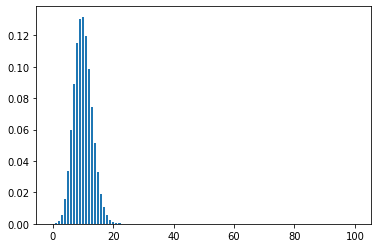

In [57]:
n_1 = 100
p_1 = 0.1

distr_1 = []

for k in range(0, n_1 + 1):
    choose = factorial(n_1) / (factorial(k) * factorial(n_1 - k))
    prob = choose * p_1**k * (1 - p_1)**(n_1 - k) 
    distr_1.append(prob)
    
plt.bar(range(0, n_1 + 1), distr_1)

<BarContainer object of 1001 artists>

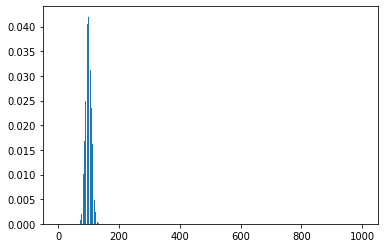

In [58]:
n_1 = 1000
p_1 = 0.1

distr_1 = []

for k in range(0, n_1 + 1):
    choose = factorial(n_1) / (factorial(k) * factorial(n_1 - k))
    prob = choose * p_1**k * (1 - p_1)**(n_1 - k) 
    distr_1.append(prob)
    
plt.bar(range(0, n_1 + 1), distr_1)

In [59]:
n_1 = 1700
p_1 = 0.05

mu_1 = n_1 * p_1
sigma_1 = sqrt(n_1 * p_1 * (1 - p_1))

distr_2 = st.norm(mu_1, sigma_1) 

result_2 = 1 - distr_2.cdf(100)

result_2

0.0475344520790022

Для текущих параметров акции, при условии, что после бесплатного пробного периода подписку продлевают 10 % пользователей, следует разослать 1700 промокодов. Это минимальное количество промокодов, при котором вероятность невыполнения плана составит примерно 5%. 

##### Задача 2.
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [60]:
n_3 = 1000000
p_3 = 0.4

mu_3 = n_3 * p_3
sigma_3 = sqrt(n_3 * p_3 * (1 - p_3))

distr_3 = st.norm(mu_3, sigma_3) 
result_3 = 1 - distr_3.cdf(399500)
print(result_3)

0.8462829170363023


Вероятность того, что из 1 млн разосланных уведомлений будет открыто не более 399,5 тыс составляет 84,6%

#### Общий вывод

Проведена аналитическая оценка популярного сервиса аренды самокатов GoFast. 
Входные данные: данные о некоторых пользователях из нескольких городов, а также об их поездках. 
Цель исследования: провести анализ данных и вынести предложения для улучшения бизнес-показателей. 

##### Предообработка данных
Входные данные были оценены с точки зрения их полноты и достаточности для анализа. Выявлено наличие пропусков в данных по столбцам. Причиной может являться человеческий фактор и технические ошибки при заполнении данных.
Исправлены типы данных в датафрейме (столбец date) 
Проведена проверка наличия пропущенных данных.
Выявлены дубликаты, проведено их удаление из данных.

##### Анализ данных
Построены круговые диаграммы и гистограммы для оценки параметров (возраст пользователей, доля использования пользователями платного и бесплатного тарифов, число пользователей в разных городах, расстояния и время использования самоката).
 
Изучили наличие зависимости цены от:
- Города: Данные распределены по всем городам достаточно равномерно, доли присутствия по разным городам в структуре составляют от 11% до 14%. Наибольшее число пользователей - Пятигорск, 219. Наименьшее - Москва, 168. 
- Тарифа: Пользователей без подписки больше, чем с подпиской - 54% против 46%.
- Возраст пользователей находится в диапазоне от 12 до 43 лет. Наибольшая часть пользователей находится в возрасте от 20 до 30 лет. Пик приходится на 24 года.
- Расстояние, которое наиболее часто проезжают расположено в диапазоне от 2.5 км до 3.7 км. Наибольшее значение расстояния составляет около 7.2 км. Минимальное значение - 0.86 м. Медианное значение - 3.07 км, среднее 1.16 км. На отметке 0.5 км наблюдается локальный пик.
- Продолжительность поездок преимущественно расположена в диапазоне от 12 до 23 минут. Минимальное значение времени поездки - 0,5 мин, что вероятно вызвано человеческим фактором (передумал ехать), либо неисправностью самоката. Пик на отметке 18 минут. Медианное значение- 17,8 м, среднее - 6,09 мин. Самая длительная поездка - 40 минут.

Данные объединены в один датасет, из него выбраны значения для двух датасетов, соответствующие платной и бесплатной подпискам. 
Проведен расчет выручки. 
Проведена проверка гипотез.
Построены распределения.

##### Выводы
После проверок гипотез получили следующий результат:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе
     - Нулевая гипотеза отвергнута. Время поездок пользователей с тарифом free не равно времени поездое пользователей с тарифом ultra. Пользователи с подпиской тратят больше времени на поездки.
- Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку
     - Не удалось отвергнуть нулевую гипотезу. Наблюдаемое значение оказалось далеко от предполагаемого в нулевой гипотезе.
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки
     - Нулевая гипотеза была отвергнута, выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free.

Для текущих параметров акции, при условии, что после бесплатного пробного периода подписку продлевают 10 % пользователей, следует разослать 1700 промокодов. Это минимальное количество промокодов, при котором вероятность невыполнения плана составит примерно 5%. 

Вероятность того, что из 1 млн разосланных push-уведомлений будет открыто не более 399,5 тыс составляет 84,6%